#### Frame Loading and Preprocessing

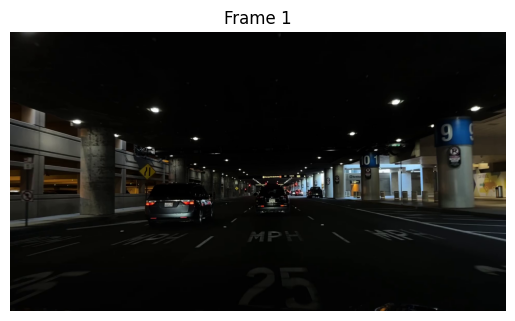

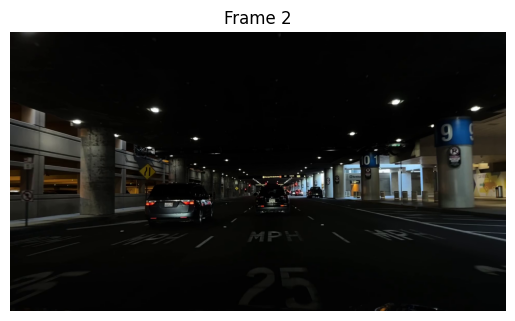

In [1]:
import cv2
from matplotlib import pyplot as plt

# Path to your video (adjust as needed)
video_path1 = '../data/leaves.mp4'
video_path2 = '../data/cars.mp4'

# Open the video
cap = cv2.VideoCapture(video_path2)

# Check if video loaded successfully
if not cap.isOpened():
    print("Error: Cannot open video.")
else:
    # Read first 30 frames and display them
    for i in range(2):
        ret, frame = cap.read()
        if not ret:
            break
        
        # Convert BGR to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Show frame
        plt.imshow(frame_rgb)
        plt.axis('off')
        plt.title(f'Frame {i+1}')
        plt.show()

cap.release()


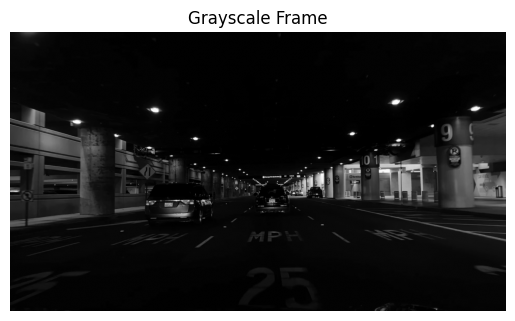

In [2]:
grey_frame = frame_rgb[:, :, 0] * 0.299 + frame_rgb[:, :, 1] * 0.587 + frame_rgb[:, :, 2] * 0.114
# Convert to grayscale
img = grey_frame.astype('uint8')
# Display the grayscale image
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title(f'Grayscale Frame')
plt.show()
        

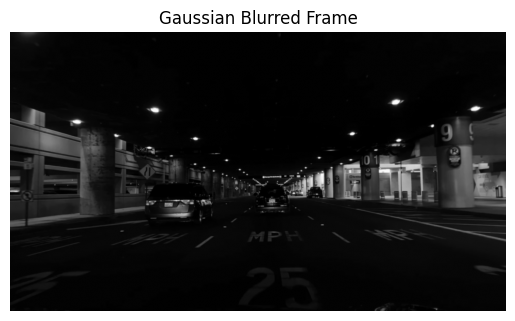

In [3]:
gaussian_blur = cv2.GaussianBlur(img, (5, 5), 0)
# Display the Gaussian blurred image    
plt.imshow(gaussian_blur, cmap='gray')
plt.axis('off')
plt.title('Gaussian Blurred Frame')
plt.show()

#### Blob Detection ( Single Frame )

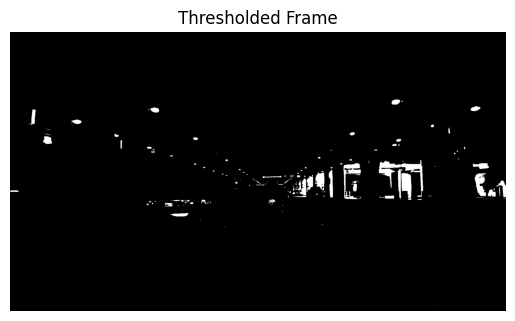

In [78]:
# Apply thresholding
thresh_img = cv2.threshold(gaussian_blur, 127, 255, cv2.THRESH_BINARY)
plt.imshow(thresh_img[1], cmap='gray')
plt.axis('off')     
plt.title('Thresholded Frame')
plt.show()

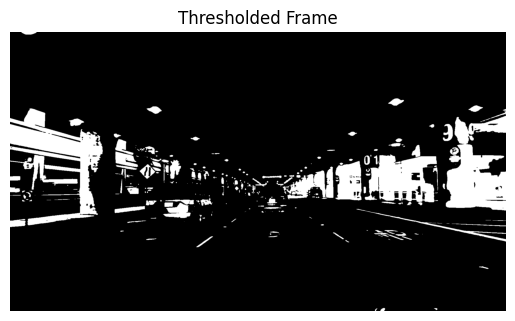

In [79]:
# Apply Otsu's thresholding
otsu_thresh_img = cv2.threshold(gaussian_blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plt.imshow(otsu_thresh_img[1], cmap='gray')
plt.axis('off')
plt.title('Thresholded Frame')
plt.show()

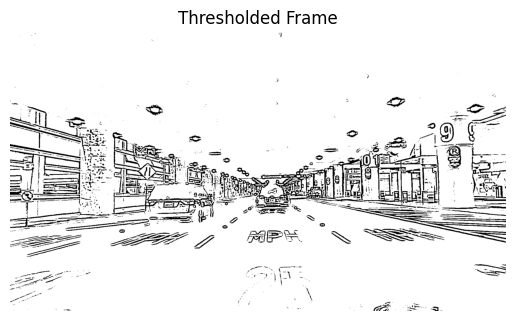

In [ ]:
# Adaptive thresholding USING Gaussian method
adaptive_thresh_img = cv2.adaptiveThreshold(gaussian_blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
plt.imshow(adaptive_thresh_img, cmap='gray')
plt.axis('off')
plt.title('Thresholded Frame')
plt.show()


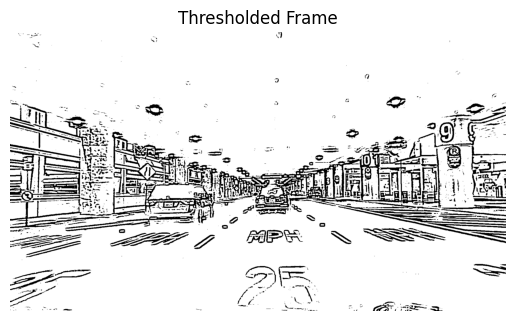

In [4]:
# Adaptive thresholding using mean
adaptive_mean_thresh_img = cv2.adaptiveThreshold(gaussian_blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
plt.imshow(adaptive_mean_thresh_img, cmap='gray')
plt.axis('off')
plt.title('Thresholded Frame')
plt.show()

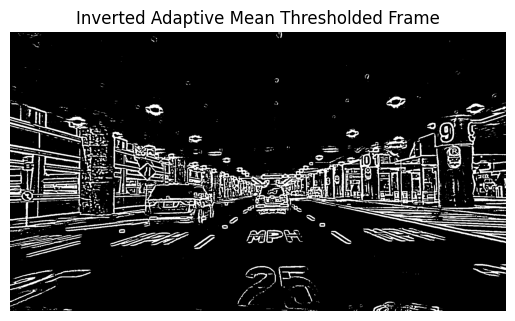

In [5]:
adaptive_mean_thresh_img = cv2.bitwise_not(adaptive_mean_thresh_img)
# Display the inverted adaptive mean thresholded image
plt.imshow(adaptive_mean_thresh_img, cmap='gray')   
plt.axis('off')
plt.title('Inverted Adaptive Mean Thresholded Frame')
plt.show()

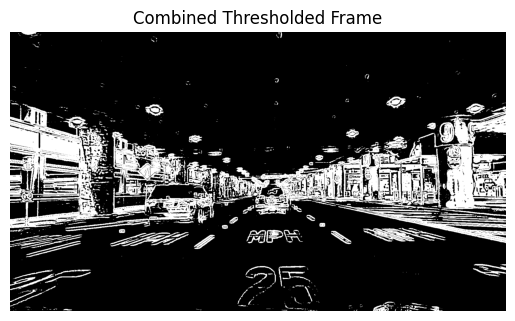

In [83]:
combined = cv2.bitwise_xor(otsu_thresh_img[1], adaptive_mean_thresh_img)
plt.imshow(combined, cmap='gray')
plt.axis('off')     
plt.title('Combined Thresholded Frame')
plt.show()

##### We will use inverted adaptive mean threshold for this analysis as it's presenting most detailed video

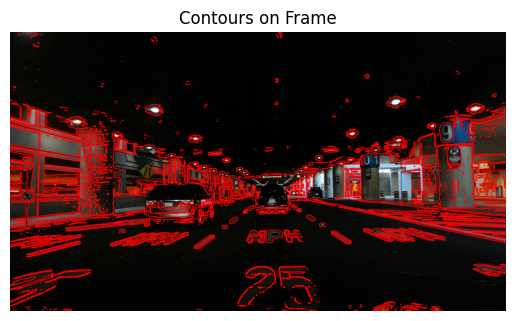

In [6]:
final_thresh =  adaptive_mean_thresh_img

contours, _ = cv2.findContours(final_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour_frame = frame_rgb.copy()
cv2.drawContours(contour_frame, contours, -1, (255, 0, 0), 2)
plt.imshow(contour_frame)
plt.axis('off')
plt.title('Contours on Frame')
plt.show()


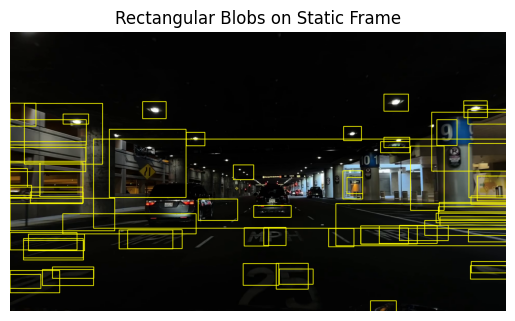

In [7]:
MIN_AREA = 500  # Adjust based on your visual preference

contours, _ = cv2.findContours(final_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour_frame = frame_rgb.copy()

for contour in contours:
    area = cv2.contourArea(contour)
    if area > MIN_AREA:
        x, y, w, h = cv2.boundingRect(contour)
        
        # Optional: Add padding for visual effect
        pad = 10
        x = max(0, x - pad)
        y = max(0, y - pad)
        w += pad * 2
        h += pad * 2

        # Draw rectangle
        cv2.rectangle(contour_frame, (x, y), (x + w, y + h), (255, 255, 0), 2)

plt.imshow(contour_frame)
plt.axis('off')
plt.title('Rectangular Blobs on Static Frame')
plt.show()


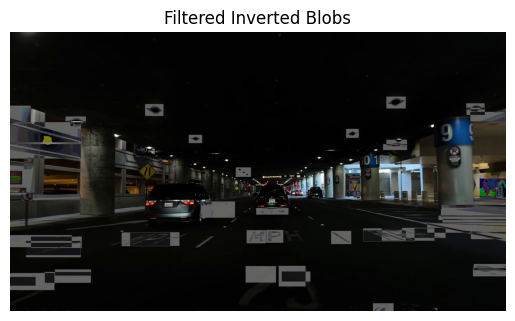

In [49]:
import numpy as np
contour_frame = frame_rgb.copy()  # Make sure you're not modifying the original

MIN_AREA = 500  # Set an absurdly high value to test filtering
MAX_AREA = 3000  # Set a maximum area to filter out very large contours

for contour in contours:
    area = cv2.contourArea(contour)
    
    if MAX_AREA > area > MIN_AREA:
        x, y, w, h = cv2.boundingRect(contour)

        # Safety check for image boundaries
        if y + h <= contour_frame.shape[0] and x + w <= contour_frame.shape[1]:
            ROI = contour_frame[y:y+h, x:x+w].copy()
            tint_color = np.array([123, 123, 123], dtype=np.uint8)  # Purple tint
            alpha = 0.8
            tinted_ROI = cv2.addWeighted(ROI, 1 - alpha , np.full_like(ROI, tint_color), alpha, 0)
            negative_ROI = cv2.bitwise_not(ROI)
            final_ROI = cv2.bitwise_and(tinted_ROI, negative_ROI)
            contour_frame[y:y+h, x:x+w] = final_ROI

plt.imshow(contour_frame)
plt.axis('off')
plt.title('Filtered Inverted Blobs')
plt.show()


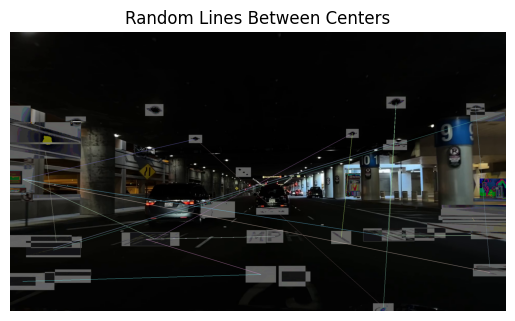

In [50]:
centers = []

# Step 1: Store the centers of qualified rectangles
for contour in contours:
    area = cv2.contourArea(contour)
    if MIN_AREA < area < MAX_AREA:
        x, y, w, h = cv2.boundingRect(contour)
        cX = x + w // 2
        cY = y + h // 2
        centers.append((cX, cY))

# Step 2: Randomly connect some of the centers with lines
num_lines = min(20, len(centers) // 2)  # don't overdraw
for _ in range(num_lines):
    pt1, pt2 = random.sample(centers, 2)
    color = tuple(np.random.randint(100, 255, size=3).tolist())
    cv2.line(contour_frame, pt1, pt2, color, thickness=1)
plt.imshow(contour_frame)
plt.axis('off') 
plt.title('Random Lines Between Centers')
plt.show()

### Video Manipulation

In [160]:
cap = cv2.VideoCapture(video_path2)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fps = cap.get(cv2.CAP_PROP_FPS)

print("Frame count:", frame_count)
print("FPS:", fps)

if fps == 0:
    print("⚠️ Warning: FPS is zero. OpenCV might not have read the video correctly.")
else:
    duration = frame_count / fps
    print(f"Duration: {duration:.2f} seconds")


Frame count: 618
FPS: 29.97002997002997
Duration: 20.62 seconds


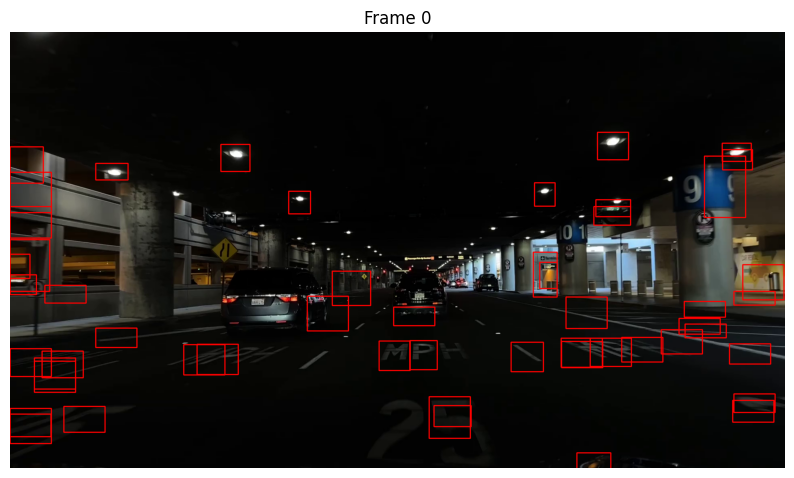

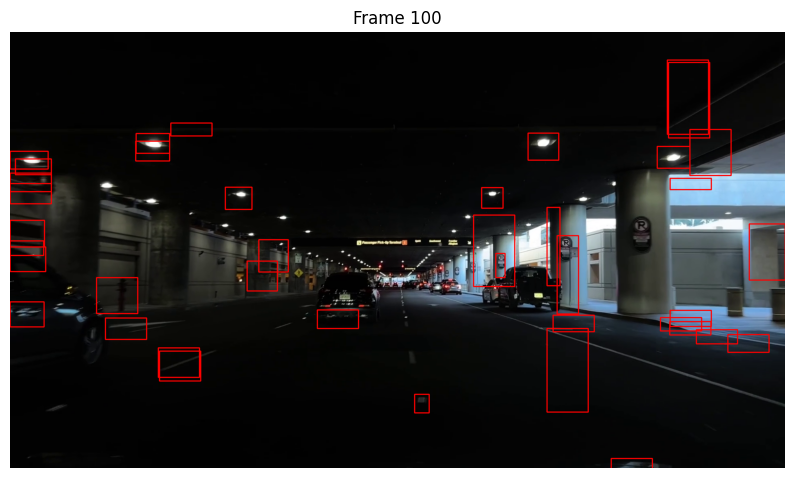

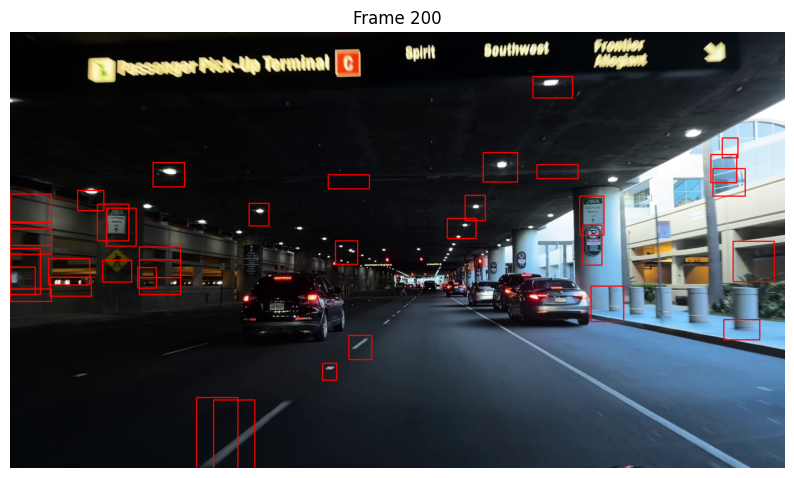

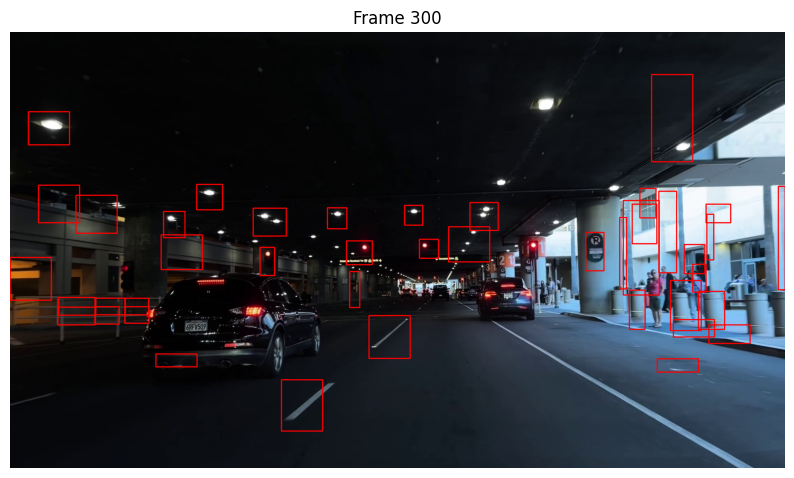

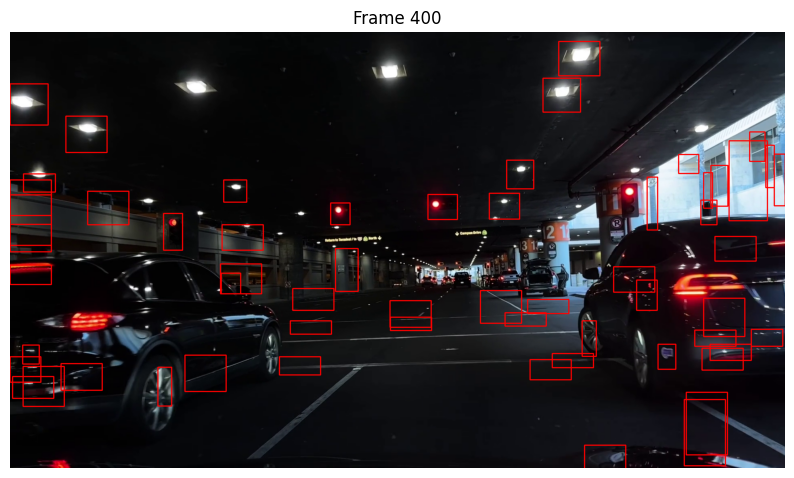

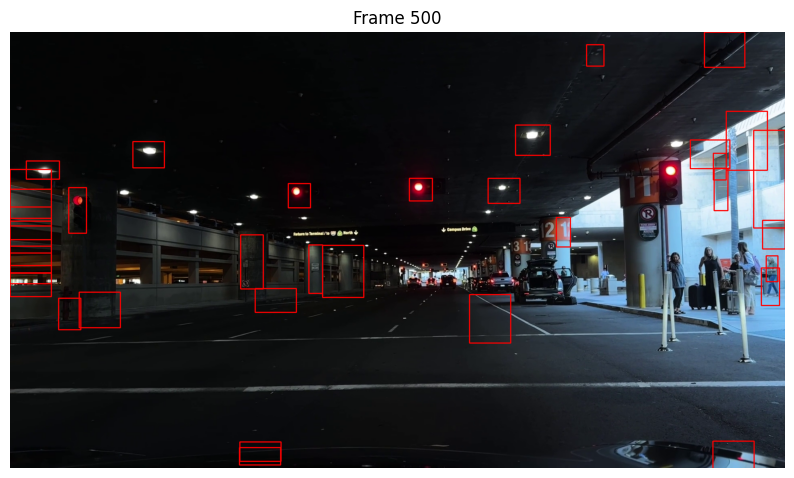

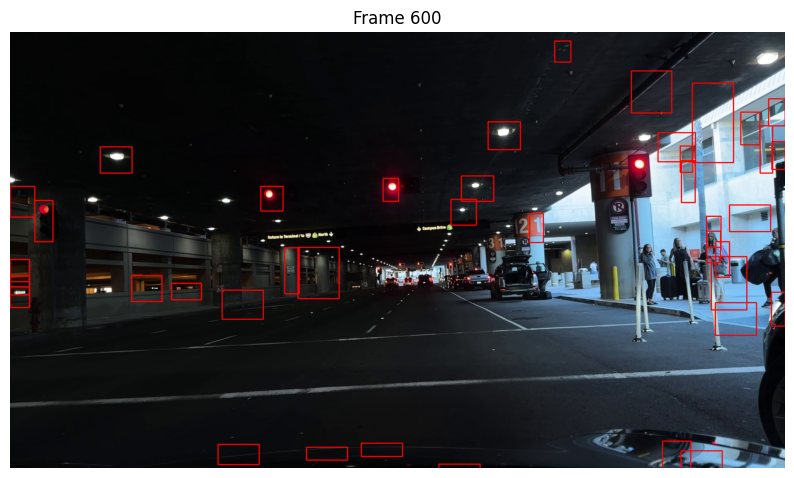

Video saved to ../videos/output.mp4


In [ ]:
cap = cv2.VideoCapture(video_path2)  # make sure 'video_path2' is defined
frame_count = 0
max_frames = 618
MIN_AREA = 500  
MAX_AREA = 3000

output_path = '../videos/output.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, 30.0, (int(cap.get(3)), int(cap.get(4))))


while cap.isOpened() and frame_count < max_frames:
    ret, frame = cap.read()
    if not ret:
        break

    # Convert frame for display and processing
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    grey_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Preprocessing
    gaussian_blur = cv2.GaussianBlur(grey_frame, (5, 5), 0)
    final_thresh = cv2.adaptiveThreshold(
        gaussian_blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY, 11, 2
    )
    final_thresh = cv2.bitwise_not(final_thresh)

    # Contour detection
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    clean_thresh = cv2.morphologyEx(final_thresh, cv2.MORPH_OPEN, kernel)
    contours, _ = cv2.findContours(final_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw bounding rectangles
    contour_frame = frame_rgb.copy()
    for contour in contours:
        area = cv2.contourArea(contour)
        if MIN_AREA < area < MAX_AREA:
            x, y, w, h = cv2.boundingRect(contour)
            MAX_WIDTH = 100 # Maximum width for rectangles
            HEIGHT_BOOST = 20
            if w > MAX_WIDTH:
                w = MAX_WIDTH
            h += HEIGHT_BOOST
            # Optional: small padding
            pad = 2
            x = max(0, x - pad)
            y = max(0, y - pad)
            w += pad 
            h += pad 

            # Draw rectangle
            cv2.rectangle(contour_frame, (x, y), (x + w, y + h), (255, 0, 0), 2)

    # Convert contour frame to BGR for saving
    contour_frame_bgr = cv2.cvtColor(contour_frame, cv2.COLOR_RGB2BGR)
    out.write(contour_frame_bgr)

    # Show every 10th frame
    if frame_count % 100 == 0:
        plt.figure(figsize=(10, 6))
        plt.imshow(contour_frame)
        plt.axis('off')
        plt.title(f'Frame {frame_count}')
        plt.show()

    frame_count += 1

cap.release()
out.release()
print(f"Video saved to {output_path}")

In [168]:
cap = cv2.VideoCapture(video_path1)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fps = cap.get(cv2.CAP_PROP_FPS)

print("Frame count:", frame_count)
print("FPS:", fps)

if fps == 0:
    print("⚠️ Warning: FPS is zero. OpenCV might not have read the video correctly.")
else:
    duration = frame_count / fps
    print(f"Duration: {duration:.2f} seconds")


Frame count: 452
FPS: 30.0
Duration: 15.07 seconds


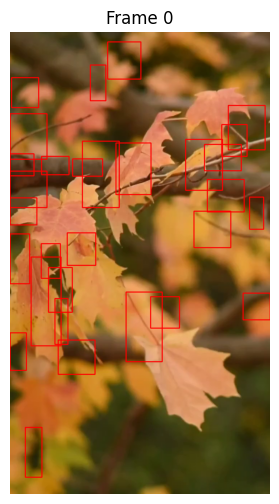

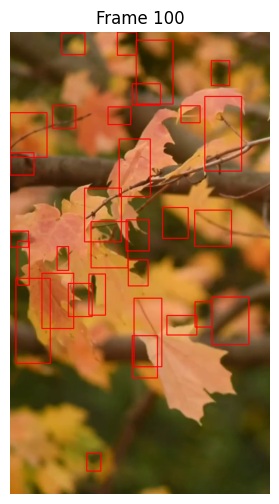

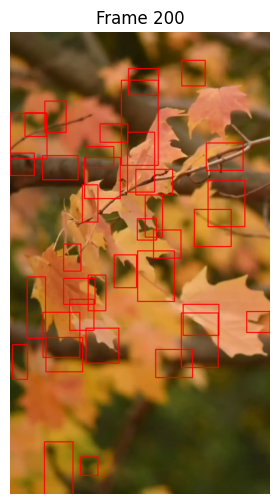

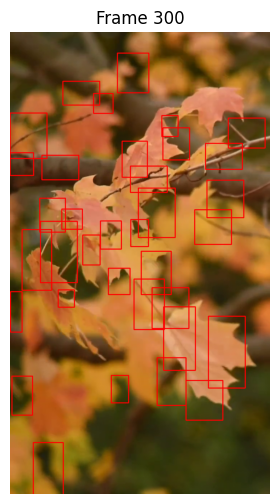

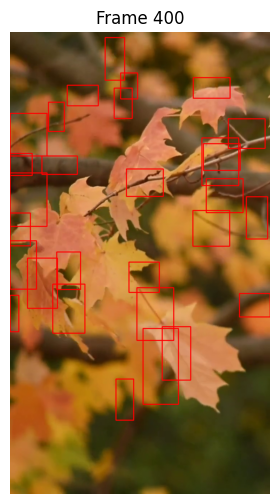

Video saved to ../videos/output_leaves.mp4


In [169]:
cap = cv2.VideoCapture(video_path1)  # make sure 'video_path2' is defined
frame_count = 0
max_frames = 452
MIN_AREA = 500  
MAX_AREA = 3000

output_path = '../videos/output_leaves.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, 30.0, (int(cap.get(3)), int(cap.get(4))))


while cap.isOpened() and frame_count < max_frames:
    ret, frame = cap.read()
    if not ret:
        break

    # Convert frame for display and processing
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    grey_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Preprocessing
    gaussian_blur = cv2.GaussianBlur(grey_frame, (5, 5), 0)
    final_thresh = cv2.adaptiveThreshold(
        gaussian_blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY, 11, 2
    )
    final_thresh = cv2.bitwise_not(final_thresh)

    # Contour detection
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    clean_thresh = cv2.morphologyEx(final_thresh, cv2.MORPH_OPEN, kernel)
    contours, _ = cv2.findContours(final_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw bounding rectangles
    contour_frame = frame_rgb.copy()
    for contour in contours:
        area = cv2.contourArea(contour)
        if MIN_AREA < area < MAX_AREA:
            x, y, w, h = cv2.boundingRect(contour)
            MAX_WIDTH = 100 # Maximum width for rectangles
            HEIGHT_BOOST = 20
            if w > MAX_WIDTH:
                w = MAX_WIDTH
            h += HEIGHT_BOOST
            # Optional: small padding
            pad = 2
            x = max(0, x - pad)
            y = max(0, y - pad)
            w += pad 
            h += pad 

            # Draw rectangle
            cv2.rectangle(contour_frame, (x, y), (x + w, y + h), (255, 0, 0), 2)

    # Convert contour frame to BGR for saving
    contour_frame_bgr = cv2.cvtColor(contour_frame, cv2.COLOR_RGB2BGR)
    out.write(contour_frame_bgr)

    # Show every 10th frame
    if frame_count % 100 == 0:
        plt.figure(figsize=(10, 6))
        plt.imshow(contour_frame)
        plt.axis('off')
        plt.title(f'Frame {frame_count}')
        plt.show()

    frame_count += 1

cap.release()
out.release()
print(f"Video saved to {output_path}")